In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from scipy.sparse import coo_matrix
from implicit.als import AlternatingLeastSquares
import scipy.sparse as sp
from scipy.sparse.linalg import svds

# Read in data and prepare for recommendation system

In [2]:
df_path = '/Users/linwang/Documents/AmaRec/'
df = pd.read_csv(df_path + 'data/processed/data_clean_kmeanlabel.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 451648 entries, 0 to 451647
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   customer_id            451648 non-null  int64 
 1   review_id              451648 non-null  object
 2   product_id             451648 non-null  object
 3   review_date            451648 non-null  object
 4   star_rating            451648 non-null  int64 
 5   raw_product_title      451648 non-null  object
 6   raw_review_headline    451646 non-null  object
 7   raw_review_body        451530 non-null  object
 8   product_title          451647 non-null  object
 9   review_headline        451033 non-null  object
 10  review_body            450864 non-null  object
 11  product cluster label  451648 non-null  int64 
 12  cluster_label          451648 non-null  object
dtypes: int64(3), object(10)
memory usage: 44.8+ MB


## EDA

<Axes: >

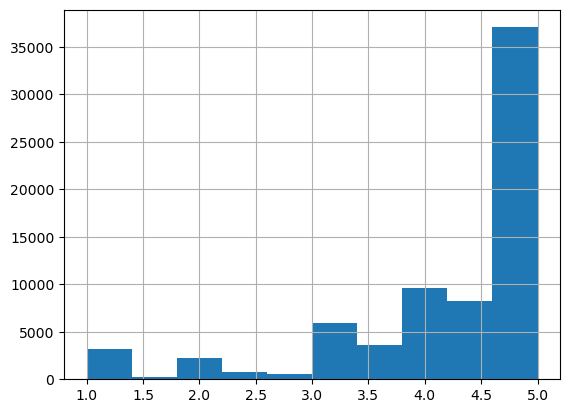

In [4]:
df.groupby('product_id')['star_rating'].mean().hist()

In [5]:
df['product_id'].value_counts().sort_values(ascending=False)

product_id
B000YDDF6O    1403
B0052QYLUM    1247
B00KDKKD1I    1213
B001OC5UMQ    1123
B00ECHYTBI    1012
              ... 
B00JE4A8TQ       1
B00O49ZUB2       1
B00KDBR52W       1
B00E3VBDK8       1
B00M9ZPFXG       1
Name: count, Length: 71585, dtype: int64

In [6]:
df['customer_id'].value_counts().sort_values(ascending=False)

customer_id
13867682    65
11357371    62
49857685    55
22632433    55
15943263    52
            ..
11595343     1
27487276     1
36436009     1
10355868     1
11938952     1
Name: count, Length: 278996, dtype: int64

In [7]:
df = df[~df['product_title'].astype(str).str.contains('discontinued', na=False)]
df = df.groupby('product cluster label').sample(1000, random_state=42)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8000 entries, 285322 to 357536
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   customer_id            8000 non-null   int64 
 1   review_id              8000 non-null   object
 2   product_id             8000 non-null   object
 3   review_date            8000 non-null   object
 4   star_rating            8000 non-null   int64 
 5   raw_product_title      8000 non-null   object
 6   raw_review_headline    7999 non-null   object
 7   raw_review_body        7998 non-null   object
 8   product_title          8000 non-null   object
 9   review_headline        7987 non-null   object
 10  review_body            7986 non-null   object
 11  product cluster label  8000 non-null   int64 
 12  cluster_label          8000 non-null   object
dtypes: int64(3), object(10)
memory usage: 875.0+ KB


## Use SVD to reduce the dimentionality of the user-item matrix

### Get user-item matrix

In [ ]:
df_piv = df_sample.pivot_table(index='customer_id',columns='product_id',values='star_rating',fill_value=0)
print(df_piv.shape)
user_item_matrix = df_piv.to_numpy()

In [ ]:
def evaluate_svd_model(user_item_matrix,X_pred):
    # Extract the ground truth ratings from the test set
    item_ground_truth = user_item_matrix[user_item_matrix.nonzero()]
    user_ground_truth = user_item_matrix[user_item_matrix.nonzero()]

    # Extract the corresponding predicted ratings
    item_pred = X_pred[user_item_matrix.nonzero()]

    # Calculate the root mean squared error (RMSE)
    item_rmse = np.sqrt(np.mean((item_ground_truth - item_pred) ** 2))
    return item_rmse
    

### Get SVD components from user-item matrix: test different K components values

In [ ]:
kcomp = np.linspace(30,100,8)
rmse_all = {}
for k in kcomp:
    u, s, vt = svds(user_item_matrix, k = k)
    s_diag_matrix=np.diag(s)
    X_pred = np.dot(np.dot(u, s_diag_matrix), vt)
    item_rmse = evaluate_svd_model(user_item_matrix,X_pred)
    rmse_all[f'{k} components'] = item_rmse
    print(f"Item-based Filtering RMSE for {k} components: {item_rmse}")

## Use ALS to reduce dimensionality of user-item matrix

### Get user-item matrix

#### Normalize rating

In [9]:
scaler = MinMaxScaler()
df['normalized_rating'] = scaler.fit_transform(df[['star_rating']])

#### Use sparse encoding

In [10]:
df_piv = df.pivot_table(index='customer_id',columns='product_id',values='normalized_rating',fill_value=0)
print(df_piv.shape)
user_item_matrix = df_piv.to_numpy()

df['customer_id'] = df['customer_id'].astype(int)
label_encoder = LabelEncoder()
df['encoded_product_id']  = label_encoder.fit_transform(df['product_id'])
#decoded_product_ids = label_encoder.inverse_transform(encoded_product_ids)

row = df['customer_id'].values
col = df['encoded_product_id'].values
data = df['normalized_rating'].values
user_item_matrix = coo_matrix((data, (row, col)))
user_item_matrix_csr = user_item_matrix.tocsr()

(7774, 5185)


### ALS model

In [14]:
model = AlternatingLeastSquares(factors=50, regularization=0.01, iterations=50)

# Fit the model to the sparse matrix
model.fit(train_matrix)

# Get the user and item factors
user_factors = model.user_factors
item_factors = model.item_factors

In [ ]:
user_factor = user_factors[1] #customer index 1
recommendation_scores = np.dot(user_factor, item_factors.T)

N = 5  # Number of recommendations to generate
top_item_indices = np.argsort(recommendation_scores)[-N:][::-1]
for item_idx in top_item_indices:
    print("Recommended item:", item_idx)

Recommended item: 5184
Recommended item: 1740
Recommended item: 1722
Recommended item: 1723
Recommended item: 1724


### Use gridsearch to identify the best ALS model

In [ ]:
train_matrix, test_matrix = train_test_split(user_item_matrix_csr, test_size=0.2, random_state=42)

model = AlternatingLeastSquares()

# Define the parameter grid for grid search
param_grid = {
    'factors': [50, 100, 200],
    'regularization': [0.01, 0.1, 1.0],
    'iterations': [20, 50, 100]
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(model, param_grid, cv=3)
grid_search.fit(train_matrix)

# Get the best ALS model from grid search
best_model = grid_search.best_estimator_

# Make predictions on the test set
test_predictions = best_model.recommend_all(test_matrix)

# Calculate RMSE
test_rmse = mean_squared_error(test_matrix.data, test_predictions.data, squared=False)

# Print the best parameters and RMSE
print("Best Parameters:", grid_search.best_params_)
print("Test RMSE:", test_rmse)